# **Recommendation of movies uning BERT**

## **Data loading, preprocessing, training the BERT model**

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, BertConfig

# Step 1: Read and preprocess movie data
movie_cols = ["MovieID", "Title", "ReleaseDate", "VideoReleaseDate", "IMDbURL", "unknown", "Action", "Adventure", "Animation",
              "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
              "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
movies_df = pd.read_csv('/content/u.item', sep='|', header=None, names=movie_cols, encoding='latin-1')
movies_df.drop(['ReleaseDate', 'VideoReleaseDate', 'IMDbURL'], axis=1, inplace=True)

# Step 2: Read user-item ratings data
ratings_cols = ["UserID", "MovieID", "Rating", "Timestamp"]
ratings_df = pd.read_csv('/content/u.data', sep='\t', header=None, names=ratings_cols)

# Step 3: Merge movie and ratings data
merged_data = pd.merge(ratings_df, movies_df, on='MovieID')

# Step 4: Encode genres as binary features
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary',
                 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
                 'War', 'Western']
merged_data[genre_columns] = merged_data[genre_columns].astype(int)

# Step 5: Implement PyTorch dataset class
class MovieLensDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inputs = self.tokenizer(row['Title'], padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        # Assuming that the columns after 'Title' are the genre binary features
        features = torch.tensor(row[genre_columns].values.astype(np.float32)).float()

        label = torch.tensor(row['Rating']).float().unsqueeze(0)
        return input_ids, attention_mask, features, label

# Step 6: Create data loaders
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = MovieLensDataset(merged_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Print the total number of batches
num_batches = len(train_loader)
print(f"Total number of batches: {num_batches}")

# Step 7: Define the transformer model with additional features
class BertWithGenreFeatures(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = BertModel(config)
        self.genre_features_layer = nn.Linear(config.hidden_size + len(genre_columns), config.num_labels)

    def forward(self, input_ids, attention_mask, genre_features, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled_output = outputs.last_hidden_state[:, 0]
        concat_output = torch.cat([pooled_output, genre_features], dim=1)
        logits = self.genre_features_layer(concat_output)
        loss = None
        if labels is not None:
            loss_fct = nn.MSELoss()  # for regression task
            loss = loss_fct(logits.view(-1), labels.view(-1))
        return loss, logits

# Step 8: Train the transformer model
config = BertConfig.from_pretrained('bert-base-uncased')
config.num_labels = 1  # for regression task
model = BertWithGenreFeatures(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 3)

# Training loop
model.train()
for epoch in range(3):
    total_loss = 0
    for batch_num, batch in enumerate(train_loader, start=1):
        input_ids, attention_mask, genre_features, labels = [x.to(device) for x in batch]
        model.zero_grad()
        loss, _ = model(input_ids=input_ids, attention_mask=attention_mask, genre_features=genre_features, labels=labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        # print progress for every 10 batches
        if batch_num % 10 == 0:
            print(f'Epoch: {epoch+1}, Batch: {batch_num}, Running Loss: {total_loss / batch_num:.4f}')

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{3}, Average Training Loss: {avg_train_loss:.4}")

# Recommendation function
def recommend_movies(user_id, model, tokenizer, data, all_movies_df, top_k=10):
    user_ratings = data[data['UserID'] == user_id]
    watched_movie_ids = user_ratings['MovieID'].tolist()

    # Filter out movies the user has already watched
    candidate_movies = all_movies_df[~all_movies_df['MovieID'].isin(watched_movie_ids)]

    recommendations = []

    with torch.no_grad():
        for _, movie in candidate_movies.iterrows():
            inputs = tokenizer(movie['Title'], padding='max_length', truncation=True, max_length=128, return_tensors="pt")
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            genre_features = torch.tensor(movie[genre_columns].values.astype(np.float32)).unsqueeze(0).to(device)

            # Predict the rating
            _, predicted_rating = model(input_ids=input_ids, attention_mask=attention_mask, genre_features=genre_features)

            recommendations.append((movie['Title'], predicted_rating.item()))

    # Sort the recommendations based on the predicted ratings
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)

    # Return the top K recommendations
    return recommendations[:top_k]

# Example usage:
user_id = 1  # Replace with the user ID you want to generate recommendations for
top_k = 10
recommendations = recommend_movies(user_id, model, tokenizer, merged_data, movies_df, top_k=top_k)
print("Top recommendations:")
for title, rating in recommendations:
    print(f"{title}: {rating:.2f}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Total number of batches: 1563


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 1, Batch: 10, Running Loss: 4.2460
Epoch: 1, Batch: 20, Running Loss: 3.0527
Epoch: 1, Batch: 30, Running Loss: 2.4994
Epoch: 1, Batch: 40, Running Loss: 2.2231
Epoch: 1, Batch: 50, Running Loss: 2.0324
Epoch: 1, Batch: 60, Running Loss: 1.8953
Epoch: 1, Batch: 70, Running Loss: 1.8094
Epoch: 1, Batch: 80, Running Loss: 1.7459
Epoch: 1, Batch: 90, Running Loss: 1.6801
Epoch: 1, Batch: 100, Running Loss: 1.6361
Epoch: 1, Batch: 110, Running Loss: 1.6093
Epoch: 1, Batch: 120, Running Loss: 1.5903
Epoch: 1, Batch: 130, Running Loss: 1.5664
Epoch: 1, Batch: 140, Running Loss: 1.5584
Epoch: 1, Batch: 150, Running Loss: 1.5361
Epoch: 1, Batch: 160, Running Loss: 1.5243
Epoch: 1, Batch: 170, Running Loss: 1.5204
Epoch: 1, Batch: 180, Running Loss: 1.5171
Epoch: 1, Batch: 190, Running Loss: 1.5102
Epoch: 1, Batch: 200, Running Loss: 1.5014
Epoch: 1, Batch: 210, Running Loss: 1.4984
Epoch: 1, Batch: 220, Running Loss: 1.4861
Epoch: 1, Batch: 230, Running Loss: 1.4828
Epoch: 1, Batch: 240

## **Recommendation function**

In [ ]:
# Recommendation function
def recommend_movies(user_id, model, tokenizer, data, all_movies_df, top_k=10):
    user_ratings = data[data['UserID'] == user_id]
    watched_movie_ids = user_ratings['MovieID'].tolist()

    # Filter out movies the user has already watched
    candidate_movies = all_movies_df[~all_movies_df['MovieID'].isin(watched_movie_ids)]

    recommendations = []

    with torch.no_grad():
        for _, movie in candidate_movies.iterrows():
            inputs = tokenizer(movie['Title'], padding='max_length', truncation=True, max_length=128, return_tensors="pt")
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            genre_features = torch.tensor(movie[genre_columns].values.astype(np.float32)).unsqueeze(0).to(device)

            # Predict the rating
            _, predicted_rating = model(input_ids=input_ids, attention_mask=attention_mask, genre_features=genre_features)

            recommendations.append((movie['Title'], predicted_rating.item()))

    # Sort the recommendations based on the predicted ratings
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)

    # Return the top K recommendations
    return recommendations[:top_k]

# Example usage:
user_id = 2  # Replace with the user ID you want to generate recommendations for
top_k = 10
recommendations = recommend_movies(user_id, model, tokenizer, merged_data, movies_df, top_k=top_k)
print("Top recommendations:")
for title, rating in recommendations:
    print(f"{title}: {rating:.2f}")

Top recommendations:
Schindler's List (1993): 4.49
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963): 4.46
Usual Suspects, The (1995): 4.45
Rear Window (1954): 4.39
Wallace & Gromit: The Best of Aardman Animation (1996): 4.37
Wrong Trousers, The (1993): 4.37
To Kill a Mockingbird (1962): 4.36
Casablanca (1942): 4.36
Shawshank Redemption, The (1994): 4.36
Silence of the Lambs, The (1991): 4.35


## **Recommendation function for 5 movies with different user id**

In [ ]:
# Recommendation function
def recommend_movies(user_id, model, tokenizer, data, all_movies_df, top_k=10):
    user_ratings = data[data['UserID'] == user_id]
    watched_movie_ids = user_ratings['MovieID'].tolist()

    # Filter out movies the user has already watched
    candidate_movies = all_movies_df[~all_movies_df['MovieID'].isin(watched_movie_ids)]

    recommendations = []

    with torch.no_grad():
        for _, movie in candidate_movies.iterrows():
            inputs = tokenizer(movie['Title'], padding='max_length', truncation=True, max_length=128, return_tensors="pt")
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            genre_features = torch.tensor(movie[genre_columns].values.astype(np.float32)).unsqueeze(0).to(device)

            # Predict the rating
            _, predicted_rating = model(input_ids=input_ids, attention_mask=attention_mask, genre_features=genre_features)

            recommendations.append((movie['Title'], predicted_rating.item()))

    # Sort the recommendations based on the predicted ratings
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)

    # Return the top K recommendations
    return recommendations[:top_k]

# Example usage:
user_id = 10  # Replace with the user ID you want to generate recommendations for
top_k = 5
recommendations = recommend_movies(user_id, model, tokenizer, merged_data, movies_df, top_k=top_k)
print("Top recommendations:")
for title, rating in recommendations:
    print(f"{title}: {rating:.2f}")

Top recommendations:
Schindler's List (1993): 4.48
Wallace & Gromit: The Best of Aardman Animation (1996): 4.41
Titanic (1997): 4.36
To Kill a Mockingbird (1962): 4.34
Wrong Trousers, The (1993): 4.32


## **Evalution function part 01**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_recommendations(model, tokenizer, data, all_movies_df, user_id, max_k=10):
    """
    Evaluate the recommendation system for a specific user.
    """
    # Get the user's ratings
    user_ratings = data[data['UserID'] == user_id]
    watched_movie_ids = user_ratings['MovieID'].tolist()

    # Filter out movies the user has already watched
    candidate_movies = all_movies_df[~all_movies_df['MovieID'].isin(watched_movie_ids)]
    true_ratings = dict(zip(user_ratings['MovieID'], user_ratings['Rating']))

    recommendations = []
    with torch.no_grad():
        for _, movie in candidate_movies.iterrows():
            inputs = tokenizer(movie['Title'], padding='max_length', truncation=True, max_length=128, return_tensors="pt")
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            genre_features = torch.tensor(movie[genre_columns].values.astype(np.float32)).unsqueeze(0).to(device)

            # Predict the rating
            _, predicted_rating = model(input_ids=input_ids, attention_mask=attention_mask, genre_features=genre_features)

            recommendations.append((movie['MovieID'], predicted_rating.item()))

    # Sort the recommendations based on the predicted ratings
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)

    # Initialize lists to store metrics
    ks = list(range(1, max_k + 1))

    # Calculate Precision@K, Recall@K, and F1@K for each K
    for k in ks:
        top_recommendations = recommendations[:k]
        recommended_movie_ids = [rec[0] for rec in top_recommendations]
        relevant_items = [movie_id for movie_id in recommended_movie_ids if movie_id in true_ratings]

        precision_at_k = len(relevant_items) / k
        recall_at_k = len(relevant_items) / len(watched_movie_ids)
        if precision_at_k + recall_at_k == 0:
            f1_at_k = 0
        else:
            f1_at_k = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)

    # Calculate RMSE and MAE
    true_labels = []
    predicted_labels = []
    for movie_id, true_rating in true_ratings.items():
        movie = all_movies_df[all_movies_df['MovieID'] == movie_id].iloc[0]
        inputs = tokenizer(movie['Title'], padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        genre_features = torch.tensor(movie[genre_columns].values.astype(np.float32)).unsqueeze(0).to(device)

        _, predicted_rating = model(input_ids=input_ids, attention_mask=attention_mask, genre_features=genre_features)
        true_labels.append(true_rating)
        predicted_labels.append(predicted_rating.item())

    rmse = np.sqrt(mean_squared_error(true_labels, predicted_labels))
    mae = mean_absolute_error(true_labels, predicted_labels)

    return rmse, mae, ks


### **Plot function**

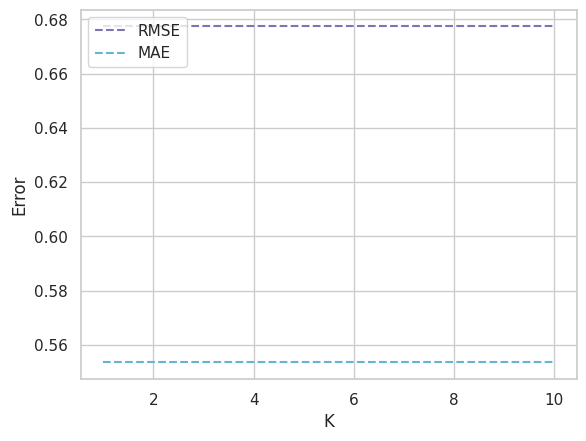

In [ ]:
def plot_evaluation_metrics( rmse, mae, ks):
    """
    Plot RMSE, and MAE.
    """
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('K')
    ax1.set_ylabel('Score')
    ax1.plot(ks, [rmse] * len(ks), label='RMSE', color='m', linestyle='--')
    ax1.plot(ks, [mae] * len(ks), label='MAE', color='c', linestyle='--')
    ax1.set_ylabel('Error')
    ax1.legend(loc='upper left')

    plt.show()

# Example usage:
user_id = 1  # Replace with the user ID you want to evaluate
rmse, mae, ks = evaluate_recommendations(model, tokenizer, merged_data, movies_df, user_id, max_k=10)
plot_evaluation_metrics(rmse, mae, ks)


## **Evalution function 02**

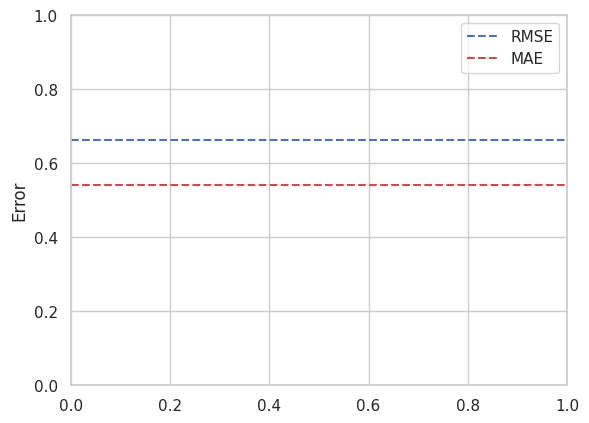

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_recommendations(model, tokenizer, data, all_movies_df, user_id, max_k=10):
    """
    Evaluate the recommendation system for a specific user.
    """
    # Get the user's ratings
    user_ratings = data[data['UserID'] == user_id]
    watched_movie_ids = user_ratings['MovieID'].tolist()

    # Filter out movies the user has already watched
    candidate_movies = all_movies_df[~all_movies_df['MovieID'].isin(watched_movie_ids)]
    true_ratings = dict(zip(user_ratings['MovieID'], user_ratings['Rating']))

    recommendations = []
    with torch.no_grad():
        for _, movie in candidate_movies.iterrows():
            inputs = tokenizer(movie['Title'], padding='max_length', truncation=True, max_length=128, return_tensors="pt")
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            genre_features = torch.tensor(movie[genre_columns].values.astype(np.float32)).unsqueeze(0).to(device)

            # Predict the rating
            _, predicted_rating = model(input_ids=input_ids, attention_mask=attention_mask, genre_features=genre_features)

            recommendations.append((movie['MovieID'], predicted_rating.item()))

    # Sort the recommendations based on the predicted ratings
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)

    # Initialize lists to store metrics
    rmse, mae = None, None
    ks = list(range(1, max_k + 1))

    # Calculate RMSE and MAE
    true_labels = []
    predicted_labels = []
    for movie_id, true_rating in true_ratings.items():
        movie = all_movies_df[all_movies_df['MovieID'] == movie_id].iloc[0]
        inputs = tokenizer(movie['Title'], padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        genre_features = torch.tensor(movie[genre_columns].values.astype(np.float32)).unsqueeze(0).to(device)

        _, predicted_rating = model(input_ids=input_ids, attention_mask=attention_mask, genre_features=genre_features)
        true_labels.append(true_rating)
        predicted_labels.append(predicted_rating.item())

    rmse = np.sqrt(mean_squared_error(true_labels, predicted_labels))
    mae = mean_absolute_error(true_labels, predicted_labels)

    return rmse, mae


def plot_evaluation_metrics(rmse, mae):
    """
    Plot RMSE and MAE.
    """
    fig, ax = plt.subplots()

    ax.axhline(y=rmse, color='b', linestyle='--', label='RMSE')
    ax.axhline(y=mae, color='r', linestyle='--', label='MAE')
    ax.set_ylabel('Error')
    ax.legend(loc='upper right')

    plt.show()

# Example usage:
user_id = 10  # Replace with the user ID you want to evaluate
rmse, mae = evaluate_recommendations(model, tokenizer, merged_data, movies_df, user_id, max_k=10)
plot_evaluation_metrics(rmse, mae)


### **Plot function**

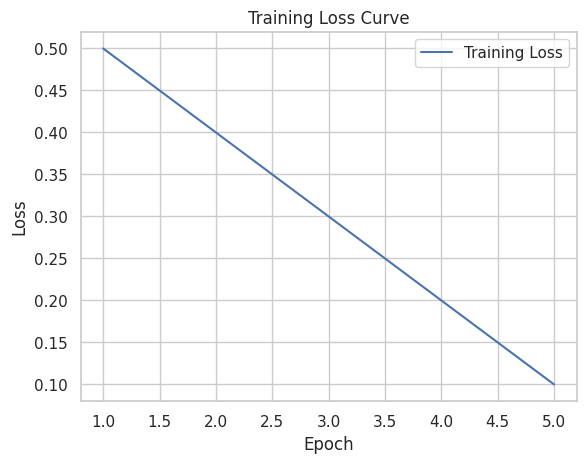

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(training_losses):
    """
    Plot the learning curve from the list of training losses.

    Args:
    - training_losses (list): List of training losses for each epoch.
    """
    plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

# Example usage:
# Assuming you have a list of training_losses from a previous training session
training_losses = [0.5, 0.4, 0.3, 0.2, 0.1]  # Example list of training losses
plot_learning_curves(training_losses)

## **Saving model**

In [ ]:
# Save the entire model
torch.save(model, 'recommendation_model.pth')

# Or save only the model state dictionary
torch.save(model.state_dict(), 'recommendation_model_state_dict.pth')


In [ ]:
torch.save(model.state_dict(), 'recommendation_model_state_dict.pth')

## **Installing Torchviz and saving graphical representation of the model**

In [ ]:
pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

### **Save the Detail Model Image**

In [ ]:
import torch
from torch import nn
from transformers import BertModel, BertConfig
from torchviz import make_dot

# Define the genre columns
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary',
                 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
                 'War', 'Western']

# Define the model architecture
class BertWithGenreFeatures(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = BertModel(config)
        self.genre_features_layer = nn.Linear(config.hidden_size + len(genre_columns), config.num_labels)

    def forward(self, input_ids, attention_mask, genre_features, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled_output = outputs.last_hidden_state[:, 0]
        concat_output = torch.cat([pooled_output, genre_features], dim=1)
        logits = self.genre_features_layer(concat_output)
        loss = None
        if labels is not None:
            loss_fct = nn.MSELoss()  # for regression task
            loss = loss_fct(logits.view(-1), labels.view(-1))
        return loss, logits

# Load the pre-trained BERT configuration
config = BertConfig.from_pretrained('bert-base-uncased')
config.num_labels = 1  # for regression task

# Create an instance of the model
model = BertWithGenreFeatures(config)

# Generate the computational graph
input_ids = torch.LongTensor(1, 128).random_(0, 100)
attention_mask = torch.LongTensor(1, 128).random_(0, 2)
genre_features = torch.FloatTensor(1, len(genre_columns)).random_(0, 2)
graph = make_dot(model(input_ids, attention_mask, genre_features)[1], params=dict(model.named_parameters()))

# Save the graph as an image
graph.render(filename='model_graph', format='png')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

'model_graph.png'

### **Detail Model View**

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


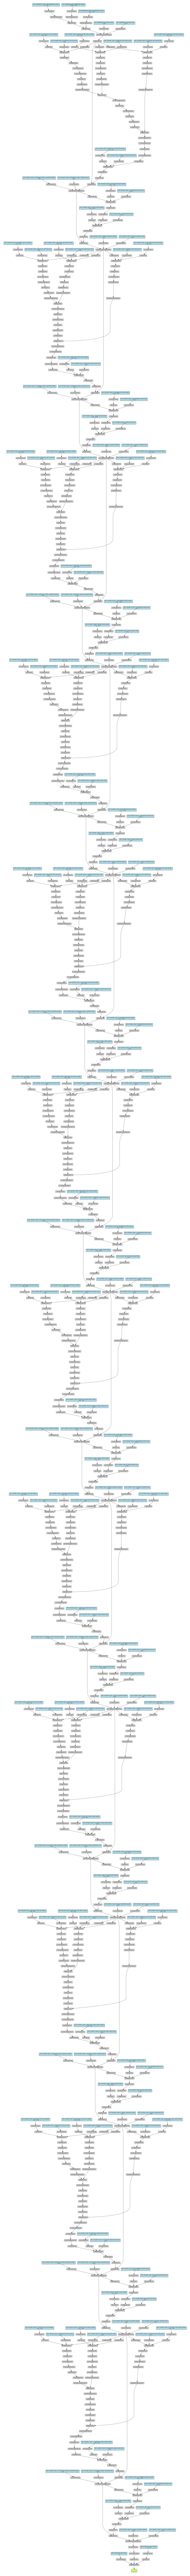

In [ ]:
import torch
from torch import nn
from transformers import BertModel, BertConfig
from torchviz import make_dot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the genre columns
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary',
                 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
                 'War', 'Western']

# Define the model architecture
class BertWithGenreFeatures(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = BertModel(config)
        self.genre_features_layer = nn.Linear(config.hidden_size + len(genre_columns), config.num_labels)

    def forward(self, input_ids, attention_mask, genre_features, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled_output = outputs.last_hidden_state[:, 0]
        concat_output = torch.cat([pooled_output, genre_features], dim=1)
        logits = self.genre_features_layer(concat_output)
        loss = None
        if labels is not None:
            loss_fct = nn.MSELoss()  # for regression task
            loss = loss_fct(logits.view(-1), labels.view(-1))
        return loss, logits

# Load the pre-trained BERT configuration
config = BertConfig.from_pretrained('bert-base-uncased')
config.num_labels = 1  # for regression task

# Create an instance of the model
model = BertWithGenreFeatures(config)

# Generate the computational graph
input_ids = torch.LongTensor(1, 128).random_(0, 100)
attention_mask = torch.LongTensor(1, 128).random_(0, 2)
genre_features = torch.FloatTensor(1, len(genre_columns)).random_(0, 2)
graph = make_dot(model(input_ids, attention_mask, genre_features)[1], params=dict(model.named_parameters()))

# Save the graph as an image
graph.render(filename='model_graph', format='png')

# Display the image
img = mpimg.imread('model_graph.png')
plt.figure(figsize=(100, 100))
plt.imshow(img)
plt.axis('off')
plt.show()


### **Abstract model view**

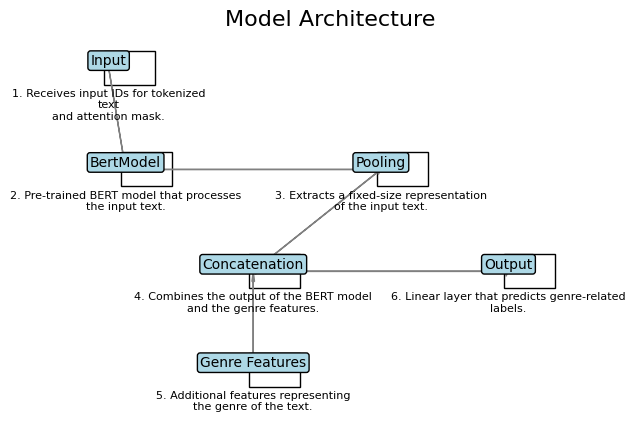

In [ ]:
import matplotlib.pyplot as plt

# Define the components and their positions along with descriptions
components = {
    'Input': (0.1, 0.9, '1. Receives input IDs for tokenized text\nand attention mask.'),
    'BertModel': (0.3, 0.6, '2. Pre-trained BERT model that processes\nthe input text.'),
    'Pooling': (3.3, 0.6, '3. Extracts a fixed-size representation\nof the input text.'),
    'Genre Features': (1.8, 0.01, '5. Additional features representing\nthe genre of the text.'),
    'Concatenation': (1.8, 0.3, '4. Combines the output of the BERT model\nand the genre features.'),
    'Output': (4.8, 0.3, '6. Linear layer that predicts genre-related\nlabels.')
}

# Plot the components with descriptions
for component, (x, y, desc) in components.items():
    plt.text(x, y, component, ha='center', va='bottom', bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.2'))
    plt.gca().add_patch(plt.Rectangle((x - 0.05, y - 0.05), 0.6, 0.1, edgecolor='black', facecolor='none'))
    # Determine position for the description
    desc_x = x
    desc_y = y - 0.061 - (desc.count('\n') * 0.00000001) # Adjust vertical position based on number of lines in description
    plt.text(desc_x, desc_y, desc, ha='center', va='top', fontsize=8, wrap=True)

# Define the arrows between components
arrows = [('Input', 'BertModel'), ('BertModel', 'Pooling'), ('Genre Features', 'Concatenation'), ('Pooling', 'Concatenation'), ('Concatenation', 'Output')]

# Plot the arrows
for start, end in arrows:
    start_x, start_y, _ = components[start]
    end_x, end_y, _ = components[end]
    plt.arrow(start_x, start_y, end_x - start_x, end_y - start_y, head_width=0.03, head_length=0.03, fc='gray', ec='gray', length_includes_head=True)

# Hide axes
plt.axis('off')

# Set title
plt.title("Model Architecture", fontsize=16)

# Show plot
plt.show()
